In [1]:
import datetime
from pathlib import Path

import numpy as np
import tensorflow as tf
from tensorflow import keras
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt

from data import example_to_tensor
from train import EarlyStopping
from utils import plot_slice, plot_animated_volume

print(f"Tensorflow: {tf.__version__}")
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

%matplotlib inline
plt.rcParams["figure.figsize"] = [15, 7]

Tensorflow: 2.3.0


In [2]:
verbose_training = True
# Hyperparameters
epochs = 1000
learning_rate = 0.0001
patience = 20
batch_size = 16
test_size = 4
validation_size = 4
xy_size = 128  # downscale 4
#z_size = 96  # downscale 4 (nrrd)
z_size = 248  # downscale 4 (tcia)
#xy_size = 256  # downscale 2
# z_size = 176  # downscale 2 (nrrd)
#z_size = 488  # downscale 2 (tcia)
# xy_size = 512   # original
# z_size = 368    # original

In [3]:
def normalize(t):
    "Normalize the input tensor in [0, 1]"
    max_value = tf.reduce_max(t)
    min_value = tf.reduce_min(t)
    return (t - min_value) / (max_value - min_value)

In [4]:
data_dir = Path("data")
tfrecord_fnames = [str(p) for p in data_dir.glob("*-0.25/*.tfrecord")]

dataset = tf.data.TFRecordDataset(tfrecord_fnames)
dataset = dataset.map(example_to_tensor)
dataset = dataset.map(normalize)
dataset = dataset.map(lambda x: tf.expand_dims(x, axis=-1))  # add the channel dimension

In [5]:
test_dataset = dataset.take(test_size)
test_dataset = test_dataset.batch(1)
dataset = dataset.skip(test_size)
dataset = dataset.padded_batch(
    batch_size=2, 
    padded_shapes=[z_size, xy_size, xy_size, 1],
)
val_dataset = dataset.take(validation_size)
train_dataset = dataset.skip(validation_size)
train_dataset = train_dataset.shuffle(buffer_size=64, reshuffle_each_iteration=True)
train_dataset = train_dataset.prefetch(tf.data.experimental.AUTOTUNE) # prefetch 16 batches
train_dataset

<PrefetchDataset shapes: (None, 248, 128, 128, 1), types: tf.float32>

In [6]:
encoder = keras.models.Sequential(
    [
        keras.layers.Conv3D(
            input_shape=[z_size, xy_size, xy_size, 1],
            filters=16,
            kernel_size=3,
            padding="same",
            kernel_initializer="lecun_normal",
            bias_initializer="lecun_normal",
        ),
        keras.layers.Activation("selu"),
        keras.layers.AlphaDropout(0.25),
        keras.layers.MaxPool3D(pool_size=2),
        keras.layers.Conv3D(
            filters=32,
            kernel_size=3,
            padding="same",
            kernel_initializer="lecun_normal",
            bias_initializer="lecun_normal",
        ),
        keras.layers.Activation("selu"),
        keras.layers.AlphaDropout(0.25),
        keras.layers.MaxPool3D(pool_size=2),
        keras.layers.Conv3D(
            filters=64,
            kernel_size=3,
            padding="same",
            kernel_initializer="lecun_normal",
            bias_initializer="lecun_normal",
        ),
        keras.layers.Activation("selu"),
        keras.layers.AlphaDropout(0.25),
        keras.layers.MaxPool3D(pool_size=2),
    ]
)
encoder.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d (Conv3D)              (None, 248, 128, 128, 16) 448       
_________________________________________________________________
activation (Activation)      (None, 248, 128, 128, 16) 0         
_________________________________________________________________
alpha_dropout (AlphaDropout) (None, 248, 128, 128, 16) 0         
_________________________________________________________________
max_pooling3d (MaxPooling3D) (None, 124, 64, 64, 16)   0         
_________________________________________________________________
conv3d_1 (Conv3D)            (None, 124, 64, 64, 32)   13856     
_________________________________________________________________
activation_1 (Activation)    (None, 124, 64, 64, 32)   0         
_________________________________________________________________
alpha_dropout_1 (AlphaDropou (None, 124, 64, 64, 32)   0

In [7]:
decoder = keras.models.Sequential(
    [
        keras.layers.UpSampling3D(
            input_shape=encoder.layers[-1].output.shape[1:], size=2,
        ),
        keras.layers.Conv3D(
            filters=64,
            kernel_size=3,
            padding="same",
            kernel_initializer="lecun_normal",
            bias_initializer="lecun_normal",
        ),
        keras.layers.Activation("selu"),
        keras.layers.AlphaDropout(0.25),
        keras.layers.UpSampling3D(size=2,),
        keras.layers.Conv3D(
            filters=32,
            kernel_size=3,
            padding="same",
            kernel_initializer="lecun_normal",
            bias_initializer="lecun_normal",
        ),
        keras.layers.Activation("selu"),
        keras.layers.AlphaDropout(0.25),
        keras.layers.UpSampling3D(size=2,),
        keras.layers.Conv3D(
            filters=16,
            kernel_size=3,
            padding="same",
            kernel_initializer="lecun_normal",
            bias_initializer="lecun_normal",
        ),
        keras.layers.Activation("selu"),
        keras.layers.AlphaDropout(0.25),
        keras.layers.Dense(1),
        keras.layers.Activation("sigmoid"),
    ]
)
decoder.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
up_sampling3d (UpSampling3D) (None, 62, 32, 32, 64)    0         
_________________________________________________________________
conv3d_3 (Conv3D)            (None, 62, 32, 32, 64)    110656    
_________________________________________________________________
activation_3 (Activation)    (None, 62, 32, 32, 64)    0         
_________________________________________________________________
alpha_dropout_3 (AlphaDropou (None, 62, 32, 32, 64)    0         
_________________________________________________________________
up_sampling3d_1 (UpSampling3 (None, 124, 64, 64, 64)   0         
_________________________________________________________________
conv3d_4 (Conv3D)            (None, 124, 64, 64, 32)   55328     
_________________________________________________________________
activation_4 (Activation)    (None, 124, 64, 64, 32)  

In [8]:
autoencoder = keras.models.Sequential([encoder, decoder])
# autoencoder.load_weights("models/autoencoder/20200723-103317/best_epoch_ckpt")
# autoencoder = keras.models.load_model("models/autoencoder/20200828-212826/")

#strategy = tf.distribute.MirroredStrategy()
#print('Number of devices: {}'.format(strategy.num_replicas_in_sync))
#
#with strategy.scope():
#    autoencoder = keras.models.Sequential([encoder, decoder])

autoencoder.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential (Sequential)      (None, 31, 16, 16, 64)    69664     
_________________________________________________________________
sequential_1 (Sequential)    (None, 248, 128, 128, 1)  179841    
Total params: 249,505
Trainable params: 249,505
Non-trainable params: 0
_________________________________________________________________


In [9]:
loss_fn = keras.losses.MeanSquaredError()
optimizer = keras.optimizers.Adam(lr=learning_rate)

In [10]:
current_time = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
log_dir = f"logs/autoencoder/{current_time}/"
model_dir = f"models/autoencoder/{current_time}/"
ckpt_dir = model_dir + "best_epoch_ckpt"
writer = tf.summary.create_file_writer(log_dir)
early_stopping = EarlyStopping(patience)

for epoch in tqdm(range(epochs), disable=False):
    
    ### TRAIN ###
    
    train_loss_metric = tf.keras.metrics.Mean("train_loss", dtype=tf.float32)
    for batch in train_dataset:
        with tf.GradientTape() as tape:
            predictions = autoencoder(batch)
            loss_value = loss_fn(predictions, batch)
        gradients = tape.gradient(loss_value, autoencoder.trainable_variables)
        optimizer.apply_gradients(zip(gradients, autoencoder.trainable_variables))
        train_loss_metric.update_state(loss_value)
        #with writer.as_default():
        #    for grad, param in zip(gradients, autoencoder.trainable_variables):
        #        tf.summary.histogram(param.name, param, step=epoch)
        #        # tf.summary.histogram(param.name + "/grad", grad, buckets=1, step=epoch)

    train_loss_mean = train_loss_metric.result()
    with writer.as_default():
        tf.summary.scalar("Training loss", train_loss_mean, step=epoch)
    train_loss_metric.reset_states()
   
   ### VALIDATION ###

    val_loss_metric = tf.keras.metrics.Mean("val_loss", dtype=tf.float32)
    for batch in val_dataset:
        predictions = autoencoder(batch)
        val_loss_metric.update_state(loss_fn(predictions, batch))

    val_loss_mean = val_loss_metric.result()
    with writer.as_default():
        tf.summary.scalar("Validation loss", val_loss_mean, step=epoch)
    val_loss_metric.reset_states()

    if verbose_training:
        print()
        print(f"Epoch : {epoch}")
        print(f"Training loss: {train_loss_mean}")
        print(f"Validation loss: {val_loss_mean}")
    
    ### EARLY STOPPING ###
    
    early_stopping.update(val_loss_mean)
    if early_stopping.early_stop:
        autoencoder.load_weights(ckpt_dir)
        break
    elif early_stopping.not_improving_epochs == 0:
        autoencoder.save_weights(ckpt_dir)

autoencoder.save(model_dir)

with writer.as_default():
    tf.summary.text(
        "Hyperparameters",
        f"batch size = {batch_size}; "
        f"patience = {patience}; "
        f"learning rate = {learning_rate}",
        step=0,
    )


Epoch : 0
Training loss: 0.0032693480607122183
Validation loss: 0.001384069793857634

Epoch : 1
Training loss: 0.001143622794188559
Validation loss: 0.0009474305552430451

Epoch : 2
Training loss: 0.0009853736264631152
Validation loss: 0.0009203744702972472

Epoch : 3
Training loss: 0.000819837732706219
Validation loss: 0.0004905114183202386

Epoch : 4
Training loss: 0.0008904623682610691
Validation loss: 0.00043215521145612

Epoch : 5
Training loss: 0.0006477336282841861
Validation loss: 0.0003768492315430194

Epoch : 6
Training loss: 0.0009835358941927552
Validation loss: 0.0004083261010237038

Epoch : 7
Training loss: 0.0005972947692498565
Validation loss: 0.00033932796213775873

Epoch : 8
Training loss: 0.0005539780831895769
Validation loss: 0.0002903995628003031

Epoch : 9
Training loss: 0.0005190509837120771
Validation loss: 0.0002714270958676934

Epoch : 10
Training loss: 0.0005173659883439541
Validation loss: 0.0002582949528004974

Epoch : 11
Training loss: 0.00051946012536063


Epoch : 93
Training loss: 0.00020069397578481585
Validation loss: 8.881712710717693e-05

Epoch : 94
Training loss: 0.00036646833177655935
Validation loss: 0.0005547091132029891

Epoch : 95
Training loss: 0.00029499383526854217
Validation loss: 8.472731133224443e-05

Epoch : 96
Training loss: 0.00020727708761114627
Validation loss: 8.287177479360253e-05

Epoch : 97
Training loss: 0.0002722508506849408
Validation loss: 8.062797132879496e-05

Epoch : 98
Training loss: 0.0001994337362702936
Validation loss: 0.0001152108161477372

Epoch : 99
Training loss: 0.00024028895131777972
Validation loss: 7.711890066275373e-05

Epoch : 100
Training loss: 0.00019350869115442038
Validation loss: 7.65484364819713e-05

Epoch : 101
Training loss: 0.00019258313113823533
Validation loss: 7.583088154206052e-05

Epoch : 102
Training loss: 0.00019074436568189412
Validation loss: 7.430303958244622e-05

Epoch : 103
Training loss: 0.00019044439250137657
Validation loss: 7.405097130686045e-05

Epoch : 104
Trainin


Epoch : 185
Training loss: 0.0001584099663887173
Validation loss: 6.225260585779324e-05

Epoch : 186
Training loss: 0.00021455598471220583
Validation loss: 6.66477280901745e-05

Epoch : 187
Training loss: 0.00015646022802684456
Validation loss: 5.806667832075618e-05

Epoch : 188
Training loss: 0.0001521385129308328
Validation loss: 6.329489406198263e-05

Epoch : 189
Training loss: 0.00015704050019849092
Validation loss: 5.988455450278707e-05

Epoch : 190
Training loss: 0.0001471969299018383
Validation loss: 5.57777239009738e-05

Epoch : 191
Training loss: 0.00014662621833849698
Validation loss: 5.534015508601442e-05

Epoch : 192
Training loss: 0.00026113426429219544
Validation loss: 6.567683885805309e-05

Epoch : 193
Training loss: 0.00015255359176080674
Validation loss: 5.762211003457196e-05

Epoch : 194
Training loss: 0.00014817439659964293
Validation loss: 5.831088128616102e-05

Epoch : 195
Training loss: 0.00014735711738467216
Validation loss: 5.646367571898736e-05

Epoch : 196
Tr


Epoch : 277
Training loss: 0.00013095253962092102
Validation loss: 4.958909630659036e-05

Epoch : 278
Training loss: 0.0001329731458099559
Validation loss: 5.445664282888174e-05

Epoch : 279
Training loss: 0.00034161328221671283
Validation loss: 6.597333413083106e-05

Epoch : 280
Training loss: 0.00015178386820480227
Validation loss: 5.8495032135397196e-05

Epoch : 281
Training loss: 0.00014170586655382067
Validation loss: 5.5811138736316934e-05

Epoch : 282
Training loss: 0.00013760579167865217
Validation loss: 5.321116259437986e-05

Epoch : 283
Training loss: 0.00013532181037589908
Validation loss: 5.202595639275387e-05

Epoch : 284
Training loss: 0.00013395000132732093
Validation loss: 5.1456427172524855e-05

Epoch : 285
Training loss: 0.0001329661172349006
Validation loss: 5.1200728194089606e-05

Epoch : 286
Training loss: 0.00013207360461819917
Validation loss: 5.4871634347364306e-05

Epoch : 287
Training loss: 0.0001325252087553963
Validation loss: 5.026358485338278e-05

Epoch :

In [27]:
%reload_ext tensorboard
%tensorboard --logdir=logs --bind_all

Reusing TensorBoard on port 6006 (pid 142900), started 0:01:20 ago. (Use '!kill 142900' to kill it.)

In [21]:
original = next(iter(train_dataset))
encoder_out = autoencoder.layers[0](original)
decoder_out = autoencoder.layers[1](encoder_out)
batch_index = 0

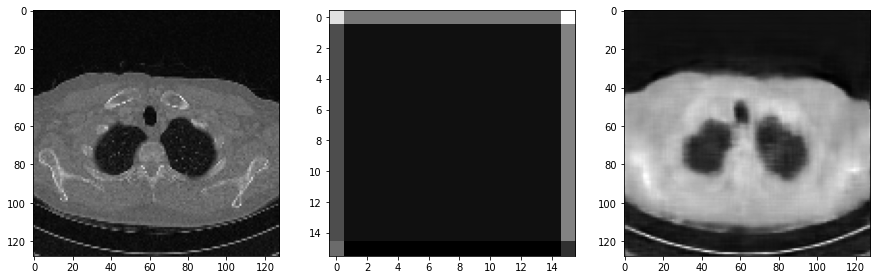

In [22]:
z_index = 20
fig, ax = plt.subplots(ncols=3)
plot_slice(original, batch_index, z_index, ax[0])
plot_slice(encoder_out, batch_index, encoder_out.shape[1] // 3, ax[1])
plot_slice(decoder_out, batch_index, z_index, ax[2])

In [23]:
plot_animated_volume(original, batch_index)

In [24]:
plot_animated_volume(encoder_out, batch_index, fps=10)

In [25]:
plot_animated_volume(decoder_out, batch_index)